In [1]:
import numpy as np
from river.drift import ADWIN

class Node:
    def __init__(self, is_leaf=True, prediction=None):
        self.is_leaf = is_leaf
        self.prediction = prediction
        self.split_feature = None
        self.split_value = None
        self.children = {}
        self.class_counts = np.zeros(2)
        self.data_batch = []
        self.label_batch = []
        self.adwin = ADWIN()
        self.alternate_tree = None
        self.n_predictions = 0
        self.n_correct_predictions = 0
    
    @property
    def accuracy(self):
        if self.n_predictions == 0:
            return 0
        return self.n_correct_predictions / self.n_predictions

def hoeffding_bound(R, n):
    return np.sqrt((R**2 * np.log(1/0.10)) / (2 * n))

def entropy(labels):
    # Count the occurrences of each class
    label_counts = np.bincount(labels, minlength=2)
    
    # Calculate the probabilities for each class
    probabilities = label_counts / np.sum(label_counts)
    
    # Remove probabilities equal to 0 for log2 calculation
    probabilities = probabilities[probabilities > 0]
    
    # Calculate the entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))
    
    return entropy 

def information_gain(parent_labels, left_labels, right_labels):
    # Entropy before the split
    entropy_before = entropy(parent_labels)
    
    # Weighted entropy after the split
    total_size = len(parent_labels)
    left_size = len(left_labels)
    right_size = len(right_labels)
    
    weighted_entropy = (left_size / total_size) * entropy(left_labels) + \
                        (right_size / total_size) * entropy(right_labels)

    # Information gain is the reduction in entropy
    return entropy_before - weighted_entropy

def best_split(data, labels):
    features = data.shape[1]
    best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    second_best_info = {'feature': None, 'value': None, 'info_gain': -np.inf}
    
    # Iterate though all the features
    for feature in range(features):
        
        values = np.sort(np.unique(data[:, feature])) # Expand this
        values_n = len(values) -1
        
        # Sort through the unique values
        for i in range(values_n):
            split_value = (values[i] + values[i+1]) / 2
            
            # Mark the values with lower than the split
            smaller_values = data[:, feature] <= split_value
            #Negation fo the left
            bigger_values = ~smaller_values
            
            # Calculate Information Gain
            info_gain = information_gain(labels, labels[smaller_values], labels[bigger_values])
            
            if info_gain > best_info['info_gain']:
                best_info, second_best_info = {
                    'feature': feature,
                    'value': split_value,
                    'info_gain': info_gain
                }, best_info
                
    return best_info, second_best_info

class HAT:
    def __init__(self, batch_size=50):
        self.root = Node(is_leaf=True, prediction=0)
        self.batch_size = batch_size
        self.alt_trees = 0
        self.pruned_trees = 0

    def _fit_single(self, x, y, node=None):
        y = y - 1
        if node == None:
            node = self.root
        while not node.is_leaf:
            old_prediction = node.prediction
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
                node.adwin.update(1 if y != old_prediction else 0)
                if node.adwin.drift_detected:
                    if node.alternate_tree is None:
                        self.alt_trees += 1
                        node.alternate_tree = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                    self._fit_single(x, y, node.alternate_tree)
            else:
                node = node.children['right']
                node.adwin.update(1 if y != old_prediction else 0)
                if node.adwin.drift_detected:
                    if node.alternate_tree is None:
                        self.alt_trees += 1
                        node.alternate_tree = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                    self._fit_single(x, y, node.alternate_tree)

        node.data_batch.append(x)
        node.label_batch.append(y)
        node.class_counts[y] += 1
        node.prediction = np.argmax(node.class_counts)

        if node.prediction == y:
            node.n_correct_predictions += 1
        node.n_predictions += 1

        if node.is_leaf and len(node.data_batch) >= self.batch_size:  
            self._attempt_to_split(node)
            node.data_batch = []
            node.label_batch = []
        
        old_prediction = node.prediction
        node.adwin.update(1 if y != old_prediction else 0)
        
        if node.adwin.drift_detected:
            if node.alternate_tree is None:
                self.alt_trees += 1
                node.alternate_tree = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
            self._fit_single(x, y, node.alternate_tree)
            
        if node.alternate_tree:
            main_tree_accuracy = node.accuracy
            alt_tree_accuracy = node.alternate_tree.accuracy
            if alt_tree_accuracy > main_tree_accuracy:
                self.pruned_trees += 1
                node.is_leaf = node.alternate_tree.is_leaf
                node.split_feature = node.alternate_tree.split_feature
                node.split_value = node.alternate_tree.split_value
                node.children = node.alternate_tree.children
                node.n_correct_predictions = node.alternate_tree.n_correct_predictions
                node.n_predictions = node.alternate_tree.n_predictions

    def _attempt_to_split(self, node):
        X_sub = np.array(node.data_batch)
        y_sub = np.array(node.label_batch)
        
        best_info, second_best_info = best_split(X_sub, y_sub)
        if best_info['feature'] is not None: 
            n = np.sum(node.class_counts)
            epsilon = hoeffding_bound(1, n)
            
            # Check if the split is significant
            if best_info['info_gain'] - second_best_info['info_gain'] > epsilon:
                node.is_leaf = False
                node.split_feature = best_info['feature']
                node.split_value = best_info['value']
                node.children['left'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))
                node.children['right'] = Node(is_leaf=True, prediction=np.argmax(node.class_counts))

        node.data_batch = []
        node.label_batch = []

    def predict(self, x):
        node = self.root
        while not node.is_leaf:
            if x[node.split_feature] <= node.split_value:
                node = node.children['left']
            else:
                node = node.children['right']

        pred = node.prediction + 1
        return pred

In [2]:
file_path = 'Skin_NonSkin 2.txt'

# Load the data
data = np.loadtxt(file_path, delimiter='\t')

# Split the data into features and target variable
X = data[:, :-1]
y = data[:, -1].astype(int) 

In [3]:
model = HAT()

errors_count = 0
error_rates = []

for i in range(len(y)):
    pred = model.predict(X[i])

    if pred != y[i]:
        errors_count += 1
        
    # Calculate Error Rate
    if i > 10000:
        error_rate = errors_count / (i + 1)
        error_rates.append([i, error_rate])
    
    # Print Every 10000 Iterations
    if i % 10000 == 0:
        print(f'Instance: {i}')
    
    model._fit_single(X[i], y[i])
print(model.pruned_trees)
print(model.alt_trees)

Instance: 0
Instance: 10000
Instance: 20000
Instance: 30000
Instance: 40000
Instance: 50000
Instance: 60000
Instance: 70000
Instance: 80000
Instance: 90000
Instance: 100000
Instance: 110000
Instance: 120000
Instance: 130000
Instance: 140000
Instance: 150000
Instance: 160000
Instance: 170000
Instance: 180000
Instance: 190000
Instance: 200000
Instance: 210000
Instance: 220000
Instance: 230000
Instance: 240000
546
760


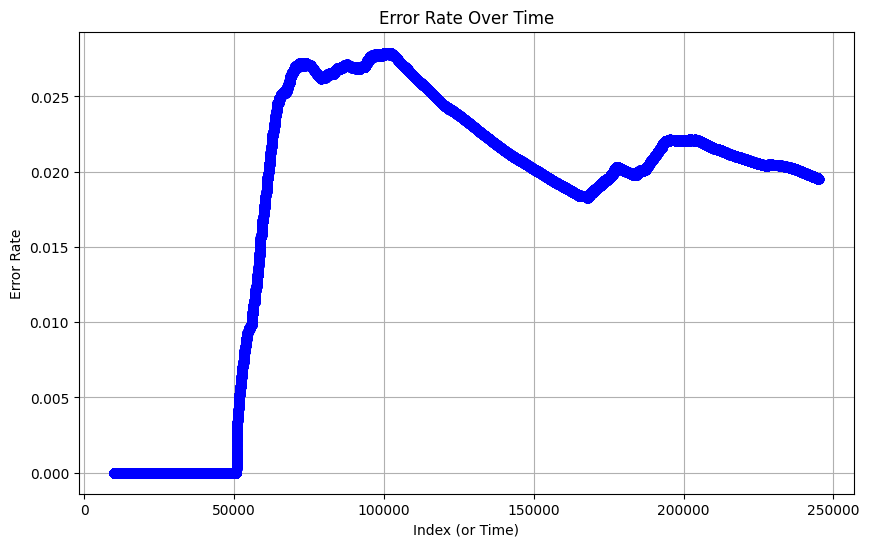

In [4]:
import matplotlib.pyplot as plt

# Splitting the list into two lists, idxs and errors
idxs, errors = zip(*error_rates)

# Plotting
plt.figure(figsize=(10, 6))  # Optional: Specifies the figure size
plt.plot(idxs, errors, marker='o', linestyle='-', color='b')  # Marker, linestyle, and color are optional
plt.title('Error Rate Over Time')
plt.xlabel('Index (or Time)')
plt.ylabel('Error Rate')
plt.grid(True)  # Optional: Adds a grid for easier reading
plt.show()